# Homework 4

## Question 1 Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

### Import data zip

In [2]:
import zipfile
import glob

zf = zipfile.ZipFile("./compustat.zip")
df = pd.read_csv(zf.open("compustat.csv"))

In [3]:
df.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,cusip,curcdq,datacqtr,datafqtr,cshoq,saleq,costat,prccq,sic
0,1000,19660331,1966,1,INDL,C,D,STD,000032102,USD,1966Q1,1966Q1,0.219,NaN,I,NaN,3089.0
1,1000,19660630,1966,2,INDL,C,D,STD,000032102,USD,1966Q2,1966Q2,0.219,NaN,I,NaN,3089.0
2,1000,19660930,1966,3,INDL,C,D,STD,000032102,USD,1966Q3,1966Q3,0.219,NaN,I,NaN,3089.0
3,1000,19661231,1966,4,INDL,C,D,STD,000032102,USD,1966Q4,1966Q4,0.219,4.032,I,NaN,3089.0
4,1000,19670331,1967,1,INDL,C,D,STD,000032102,USD,1967Q1,1967Q1,0.277,NaN,I,NaN,3089.0


### 1. Take the variables that we are interested in

In [4]:
var_names = ['sic', 'datacqtr', 'cusip', 'cshoq', 'saleq', 'prccq']
df = df[var_names]

In [5]:
df.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq
0,3089.0,1966Q1,000032102,0.219,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN


### 2. Analyze saleq and market cap

In [6]:
# Calculate market cap from the existing indicators
df['mrkcap'] = df['cshoq'] * df['prccq']

In [7]:
def stats(serie):
    """
    itype: pd.Series
    rtype: pd.DataFrame
    """
    mean = serie.mean()
    std = serie.std()
    nan_count = serie.isnull().sum()
    nan_ratio = nan_count / len(serie)
    return pd.DataFrame([mean, std, nan_count, nan_ratio], columns=[serie.name], index=['mean', 'standard deviation', 'missing value', 'missing rate'])

In [8]:
aggregate_stat = pd.concat([stats(df['saleq']), stats(df['mrkcap'])], axis=1)
aggregate_stat

,saleq,mrkcap
mean,445.150664,2057.473104
standard deviation,2679.706576,13202.197457
missing value,269498.000000,468276.000000
missing rate,0.148787,0.258530


### 3. Deal with outliers

- There're several ways to check for outliers, say sorting the data to see edge values; graphing the data to identify outliers(boxplot, histogram, scatterplot, etc); or using the Z-scores to detect. 
- The following implementation takes 'saleq' as an instance.

#### (i) sort the data

In [9]:
sorted_saleq = df['saleq'].sort_values().dropna()
print(sorted_saleq.head())
print(sorted_saleq.tail())

28039     -25623.000
832590    -14266.834
1715206   -12519.497
1183158   -11306.432
373951     -9832.000
Name: saleq, dtype: float64
1515668    151597.509
386228     163740.000
1515670    190805.601
386224     195805.000
1515672    207307.334
Name: saleq, dtype: float64


as can be seen, the lower bound of saleq is below 0, which violates financial principles.

#### (ii) scatter plot

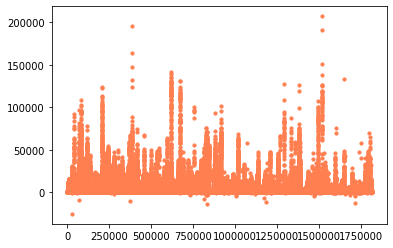

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
ax.scatter(df.index, df['saleq'], s=10, c='coral')
plt.show()

Except for the outliers below 0, there're several larger-than-normal values shown.

#### (iii) Z-score

In [11]:
def detect_outlier(data):
    """
    itype: pd.Series
    rtype: list
    """
    outliers = []
    threshold = 3
    mean = data.mean()
    std = data.std()

    for y in data:
        z_score = (y - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers


saleq_outliers = detect_outlier(df['saleq'])
print(saleq_outliers[:20])
print(len(saleq_outliers))

[9995.0, 11356.0, 11139.0, 10160.0, 9827.0, 10827.0, 10706.0, 9630.0, 9435.0, 10363.0, 10593.0, 9789.0, 9820.0, 11227.0, 10964.0, 10611.0, 10401.0, 11643.0, 11559.0, 10938.0]
15098


- The reason for below-zero outliers could be numbers mistaken( though it's kind of too much mistaken in this dataset). But for outliers given by z-score method, we could have the wrong distribution assumption for the data (if the data is not normally distributed, then the z-score has no meaning).
- Take 'saleq' as an instance, the standard deviation is about 7 times of the mean, which implies a highly dispersed distribution. Plotting the histogram (as shown below), we can see that the data has high concentration close to 0. Then the variance is mostly provided by the upper tail.

#### Histogram to show empirical distribution

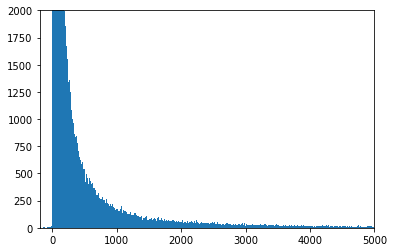

In [12]:
_ = plt.hist(df['saleq'].dropna().values, bins='auto')
plt.axis([-200, 5000, 0, 2000])
plt.show()

## Question 2: Compute Industry Concentration

The definition of HHI:  

\begin{equation}
HHI = s_1^2 +s_2^2+s_3^2+...+s_n^2
\end{equation}

where
$s_n^2$ = the market share percentage of firm $n$ expressed as a whole number, not a decimal.

In [13]:
df.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq,mrkcap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


In [14]:
# Take the first two digit of sic as the industry code.
df['sic'] = df['sic'].astype('str')
df['indcode'] = df['sic'].str[:2]

In [15]:
# Drop nan data
df.dropna(inplace=True)
# Sum the market cap over per industry and per quarter
df['indmrkcap'] = df.groupby(by=['indcode', 'datacqtr'])[
    'mrkcap'].transform('sum')
# Compute the market share as a whole number (which is market cap share in this context)
df['mrkshr'] = df['mrkcap'] / df['indmrkcap'] * 100
# Square market share
df['mrkshr_sq'] = df['mrkshr'] ** 2
# Compute the HHI index per industry and per quarter
HHI = df.groupby(by=['indcode', 'datacqtr'])['mrkshr_sq'].sum()
HHI = HHI.to_frame(name='HHI')

In [16]:
# Compute average HHI
average_HHI = HHI.groupby(by='indcode').mean()
# Drop the HHI above 10,000
average_HHI_below_10000 = average_HHI[average_HHI < 10000]
top4 = average_HHI_below_10000.sort_values(by='HHI', ascending=False)[:4]
top4

,HHI
indcode,
na,9409.498186
81,9362.460875
90,9298.617817
84,9142.942037


So the 4 industries that has the greatest HHI are with code 81, 90, 84, 41.

#### Time series plot

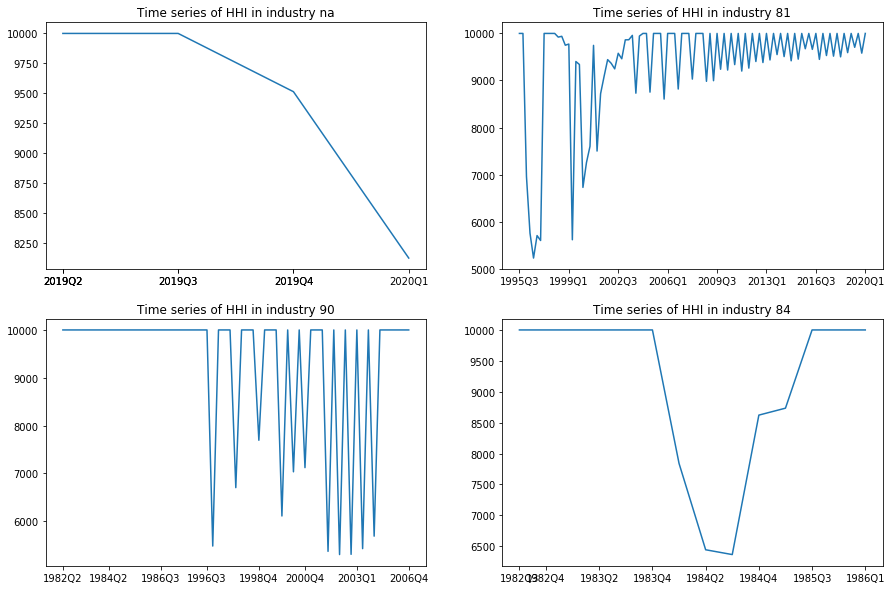

In [17]:
codes = top4.index.tolist()
plt.figure(figsize=(15, 10))

for i, code in enumerate(codes):
    plt.subplot(2, 2, i+1)
    plt.plot(HHI.loc[code])

    plt.title('Time series of HHI in industry %s' % code)

    datetime = HHI.loc[code].index.tolist()
    ticks = np.linspace(0, len(datetime)-1, 8, dtype=int)
    plt.xticks(np.array(datetime)[ticks])
plt.show()